In [3]:
import glob
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import datasets, linear_model, ensemble, neural_network
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

In [4]:
CONFIG_FILE = '../entsoe-data.config'

if not os.path.exists(CONFIG_FILE):
    download_dir = input('Path to ENTSO-E data folder: ')
    if not os.path.isdir(download_dir):
        raise RuntimeError(f'Invalid download_dir, please run cell again: {download_dir}')
    with open(CONFIG_FILE, 'w') as f:
        f.write(download_dir)
else:
    with open(CONFIG_FILE) as f:
        download_dir = f.read()
        
# Clear the output after this cell if you want to aovid having your path in the notebook (or execute it twice)!

In [5]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    data = pd.concat(each_csv_file, ignore_index=True)

    data = data.sort_values(by=["AreaName", "DateTime"])
    data = data.set_index("DateTime")

    print("Loading done.")

    return data


power_demand = load_complete_entso_e_data(download_dir)

Concatenating 68 csv files...
Loading done.


In [48]:
def get_hourly_country_data(data, country):
    ret_data = data[data["AreaName"] == country].interpolate() # data may contain NAs, therefore inteprolate
    ret_data = ret_data.resample("1h").mean().interpolate() # not all hours may be  complete 
                                                            # (i.e. some last 15 minutes are lacking, therefore another inpolation here)

    return ret_data

power_demand_at_hourly = get_hourly_country_data(power_demand, "Austria")["2017-01-01":"2019-12-31"]

In [49]:
def get_Y(data):
    Y = np.array(data["TotalLoadValue"]).reshape(-1, 1)
    
    return Y

Y = get_Y(power_demand_at_hourly)

In [50]:
def get_X(data, has_trend = False):

    #monthly_dummies = np.array(pd.get_dummies(
    #    data.index.month))
    #[:, :11]
    cos = np.cos(2 * np.pi * ((data.index.dayofyear.values - 1) * 24 + data.index.hour.values) / 8760)
    sin = np.sin(2 * np.pi * ((data.index.dayofyear.values - 1) * 24 + data.index.hour.values) / 8760)
    
    weekday = np.array(pd.get_dummies(
        data.index.weekday))
    #[:, :6]

    hour = np.array(pd.get_dummies(
        data.index.hour))
    #[:, :23]

    trend = np.arange(0, len(hour)).reshape(-1, 1)
    
   
    X_out = np.append(hour, weekday, axis=1)
    X_out = np.append(X_out, cos.reshape(-1, 1), axis=1)
    
    if(has_trend):
        X_out = np.append(X_out, trend, axis=1)
        
    return X_out
        
X = get_X(power_demand_at_hourly)


0.8132979297208867

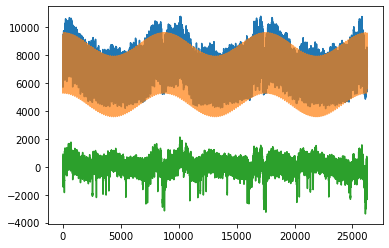

In [51]:
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(X, Y)

pred = regr.predict(X)

r2_score(Y, pred)

plt.plot(Y)
plt.plot(pred, alpha=0.7)

residues = Y - pred
plt.plot(residues)
r2_score(Y, pred)

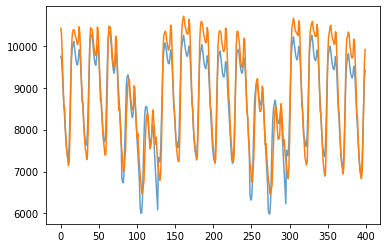

In [75]:
plt.plot(pred[400:800], alpha=0.7)

plt.plot(Y[400:800])

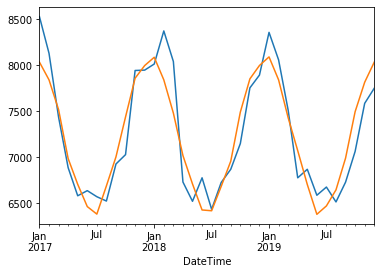

In [52]:
power_demand_at_hourly["Prediction"] = pred
power_demand_at_hourly["TotalLoadValue"].resample('1m').mean().plot()
power_demand_at_hourly["Prediction"].resample('1m').mean().plot()

In [ ]:
import xarray as xr
data = xr.load_dataset("../data/temperatures_era5_levels.nc")
temp_data = data.t2m.sel(longitude=16.5, latitude=48)
plt.plot(temp_data)



In [54]:
temp_data_year = temp_data.sel(time=slice('2017-01-01', '2019-12-31'))

temp_data_year_np = temp_data_year.values[:, 0] - 273.15

limit_heating_down = 9
limit_heating_up = 24

temp_data_year_np[(temp_data_year_np > limit_heating_down)] = limit_heating_down


In [ ]:
for i in range(0, 15):
    limit_heating = i
    temp_data_year_np = temp_data_year.values[:, 0] - 273.15

    temp_data_year_np[temp_data_year_np > limit_heating] = limit_heating
    print(i)
    print(np.corrcoef(temp_data_year_np, residues.reshape(-1,)))

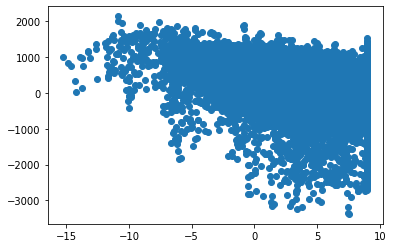

In [55]:
plt.scatter(temp_data_year_np, residues)

In [56]:
np.corrcoef(temp_data_year_np, residues.reshape(-1,))

array([[ 1.        , -0.31154839],
       [-0.31154839,  1.        ]])

In [57]:
X = get_X(power_demand_at_hourly)
X = np.append(X, temp_data_year_np.reshape(-1, 1), axis=1)

0.8452280967383824

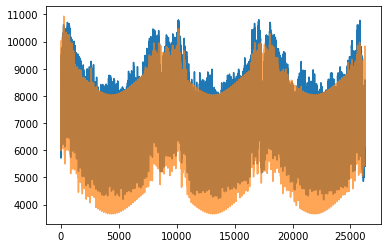

In [58]:
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(X, Y)

pred = regr.predict(X)

plt.plot(Y)
plt.plot(pred, alpha=0.7)

r2_score(Y, pred)

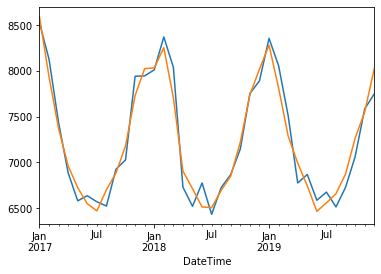

In [59]:
power_demand_at_hourly["Prediction"] = pred
power_demand_at_hourly["TotalLoadValue"].resample('1m').mean().plot()
power_demand_at_hourly["Prediction"].resample('1m').mean().plot()

In [60]:
power_demand_at_hourly_2020 =  get_hourly_country_data(power_demand, "Austria")["2020-01-01":"2020-05-20"]


In [61]:
index = pd.date_range(start='2020-01-01', end='2020-12-31', freq='H')
year_2020 = pd.DataFrame(index=index, columns=['A'])
X_2020 = get_X(year_2020)

In [62]:
temp_data_year = temp_data.sel(time=slice('2020-01-01', '2020-05-20'))


In [63]:
temp_data_year_np = temp_data_year.values[:, 0]

temp_data_year_np = temp_data_year.values[:, 0] - 273.15

limit_heating_down = 9
limit_heating_up = 24

temp_data_year_np[(temp_data_year_np > limit_heating_down)] = limit_heating_down

temp_data_year_np[np.isnan(temp_data_year_np)] = temp_data_year.values[np.isnan(temp_data_year_np), 1]

In [64]:
temp_reshaped = temp_data_year_np.reshape(-1, 1)

In [65]:
X_2020 = X_2020[:temp_reshaped.shape[0], :]
X_2020 = np.append(X_2020, temp_reshaped, axis=1)

Text(0, 0.5, 'Proportion of Observed Load to Predicted Load (%)')

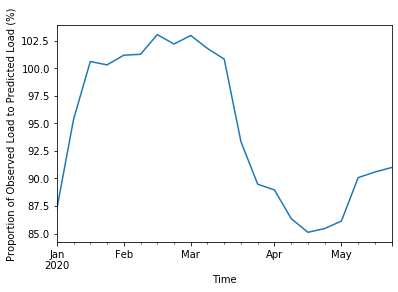

In [73]:
prediction_2020 = regr.predict(X_2020)

power_demand_at_hourly_2020["prediction"] = prediction_2020

(100*power_demand_at_hourly_2020["TotalLoadValue"]/power_demand_at_hourly_2020["prediction"]).resample('1w').mean().plot()
plt.xlabel("Time")
plt.ylabel("Proportion of Observed Load to Predicted Load (%)")

Text(0.5, 0, 'Time')

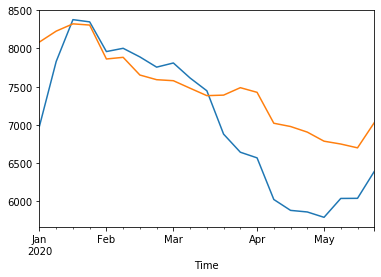

In [72]:
prediction_2020 = regr.predict(X_2020)

power_demand_at_hourly_2020["prediction"] = prediction_2020

(power_demand_at_hourly_2020["TotalLoadValue"]).resample('1w').mean().plot()
(power_demand_at_hourly_2020["prediction"]).resample('1w').mean().plot()

plt.xlabel("Time")
